# Determining haplotype groups

Imports.

In [1]:
import adjustText # prevent overlapping text
import matplotlib.pyplot as plt # make simple visualizations
import numpy as np # data management
import pandas as pd # data management
import seaborn as sns # simplified plotting interface

import genotype_helpers # various helper functions & constants
from genotype_helpers import Genotypes # type hinting

print(f'''
This notebook adds:
adjustText version {adjustText.__version__}, 
Seaborn version {sns.__version__}
''')


This helper file uses:
Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)],
Matplotlib version 3.7.1, 
NumPy version 1.24.3,
pandas version 1.5.3, 
pyMSAviz version 0.4.0,
scikit-allel version 1.3.6


This notebook adds:
adjustText version 0.8, 
Seaborn version 0.12.2



Constants.

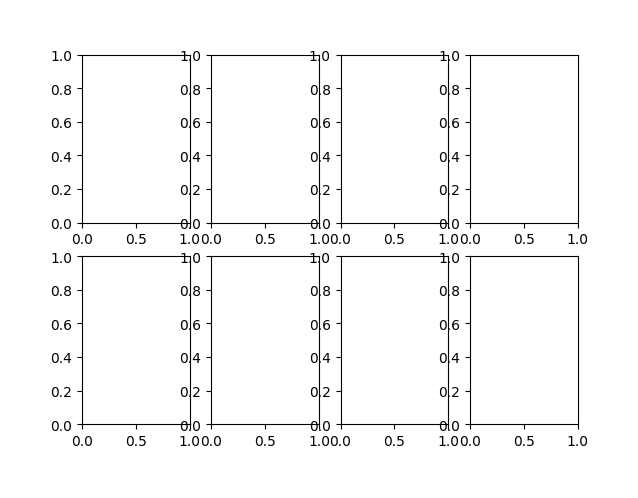

In [2]:
# style for lines which point from labels to their points
label_lines = dict(arrowstyle = '-', color = 'k', lw = 0.5, zorder = 5)
# style for backing boxes for group labels
round_box = dict(boxstyle = 'round', fc = '0.8')

# prepare master QC plot
fig, axs = plt.subplots(2, 4)
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
# convert to convenient list of tuples
plots = [(letters[i], axs[i // 4][i % 4]) for i in range(8)]


Helper functions.

In [3]:
def combined_hom_ref_vs_alt(founders: Genotypes, modern: Genotypes, 
                            chrom: str) -> pd.Series:
    """Compare the two kinds of homozygous alleles, by sample.

    Visualize if each sample favors homozygous reference or 
    alternate calls at SNPs in two Genotypes data frames.
    Note that these are the only allowed genotype calls
    since heterozygousity is treated as missing.

    `founders` and `modern` are assumed to share columns/variants.

    The plot show the number of homozygous reference SNPs on one
    axis and the number of homozygous alternate SNPs on the other.

    Parameters
    ----------
    founders: Genotypes
        Founder genotypes as a (samples x variants) shape data frame.
    modern: pd.DataFrame
        Modern genotypes as a (samples x variants) shape data frame.
    chrom: str
        Chromosome these data are for; for plot title.
    
    Returns
    -------
    favors_ref: pd.Series
        Whether each modern sample favors homozygous ref calls.
    """

    all_geno = pd.concat([founders, modern])

    # calculate counts per row/sample
    num_ref = (all_geno == 0).sum(axis = 1)
    num_alt = (all_geno == 11).sum(axis = 1)
    n_snps = all_geno.shape[1]

    # ---- plot modern samples (use histogram) ----
    
    # make scatterplot & histograms with ONLY modern samples
    p = sns.jointplot(x = num_alt.loc[modern.index], 
                      y = num_ref.loc[modern.index], 
                      # size plot to enclose all possible genotype counts
                      xlim = (0, n_snps + 1), ylim = (0, n_snps + 1),
                      # make the dots plot over the axis lines 
                      joint_kws = {'zorder': 5, 'clip_on': False})
    # shrink plot to make room for labels
    p.fig.subplots_adjust(bottom = 0.1, left = 0.15)
    p.fig.set_size_inches(5, 5)
    
    # label haplotype groups
    plt.text(n_snps * 0.1, n_snps * 0.6, f'{chrom}1', 
             fontsize = 12, bbox = round_box)
    plt.text(n_snps * 0.6, n_snps * 0.1, f'{chrom}2', 
             fontsize = 12, bbox = round_box)
    
    # --- plot founder samples (label by name) ----

    texts = []
    for name in founders.index:
        cur_x = num_alt[name] 
        cur_y = num_ref[name]

        # random shift to help with overlapping text
        texts.append(plt.text(cur_x + (2 * np.random.random() - 1), 
                              cur_y + (2 * np.random.random() - 1), 
                              name, zorder = 10))
        # ro = red circle
        plt.plot(cur_x, cur_y, 'ro', zorder = 6, clip_on = False)
    
    # ---- final touches ----

    plt.suptitle(f'Homozygous SNPs by rat on {chrom}', fontsize = 13, y = 0.95)
    plt.xlabel('# hom alt SNPs')
    plt.ylabel('# hom ref SNPs')

    # prevent overlapping text
    adjustText.adjust_text(texts, arrowprops = label_lines, lim = 5000)

    genotype_helpers.save_plot(f'{chrom}_ref_vs_alt')

    # only return groups for modern rats
    return (num_ref > num_alt).drop(founders.index).rename('favors_ref')

def label_haplotypes(favors_ref: pd.Series, chrom: str, 
                     ref_founder: str, alt_founder: str) -> pd.Series:
    """Convert ref/alt favoritism to founder haplotype assignments.

    Parameters
    ---------
    favors_ref: pd.Series
        Whether each sample favors homozygous ref calls.
    chrom: str
        Chromosome these haplotypes are of.
    ref_founder: str
        Name of the founder(s) that donated the reference haplotype.
    alt_founder: str
        Name of the founder(s) that donate the alternate haplotype.
    
    Returns
    -------
    groups: pd.Series
        Haplotype assignments for the samples.
    """

    groups = favors_ref.replace({True: f'{chrom}1 ({ref_founder})', 
                                 False: f'{chrom}2 ({alt_founder})'})
    return groups.rename(f'{chrom}_group')

Load genotypes. 

Plot filters applied to shallow-sequenced modern genotypes:
- **Y** goes on the top four subplots, *Figure S2A-D*
- **MT** goes on the bottom four subplots, *Figure S2E-H*

Founder genotypes are subset to SNPs available in modern samples,
since those is the only basis for comparison. 
No other filters are applied to the founder data.

In [4]:
y_modern = genotype_helpers.get_genotypes(
    genotype_helpers.SHALLOW_MODERN_FILE, 'Y', format = 'allele_num',
    
    filter_plots = plots[:4]
    )

Read 5227 variants across 15120 samples
7637 samples removed for not being male
Setting heterozygous calls to missing
Setting missing calls to np.nan
Filtering out 300 variants for INFO score < 0.5
Filtering out 217 variants for MAF=0
Filtering out 578 variants for % nonmissing calls < 75
Filtering out 12 samples for % nonmissing calls < 50
Genotypes for 7471 rats across 4132 variants


In [5]:
mt_modern = genotype_helpers.get_genotypes(
    genotype_helpers.SHALLOW_MODERN_FILE, 'MT', format = 'allele_num', 
    
    filter_plots = plots[4:] 
    )

Read 117 variants across 15120 samples
Setting heterozygous calls to missing
Setting missing calls to np.nan
Filtering out 0 variants for INFO score < 0.85
Filtering out 40 variants for MAF=0
Filtering out 0 variants for % nonmissing calls < 75
Filtering out 149 samples for % nonmissing calls < 50
Genotypes for 14971 rats across 77 variants


In [6]:
y_founders = genotype_helpers.get_genotypes(
    genotype_helpers.FOUNDERS_FILE, 'Y', format = 'allele_num',
    
    variant_subset = y_modern.columns, 
    use_maf_filter = False, use_miss_filter = False
    )

Read 18499 variants across 8 samples
0 samples removed for not being male
14367 variants removed for not being in the given subset
Setting heterozygous calls to missing
Setting missing calls to np.nan
Genotypes for 8 rats across 4132 variants


In [7]:
mt_founders = genotype_helpers.get_genotypes(
    genotype_helpers.FOUNDERS_FILE, 'MT', format = 'allele_num', 

    variant_subset = mt_modern.columns, 
    use_maf_filter = False, use_miss_filter = False
    )

Read 122 variants across 8 samples
45 variants removed for not being in the given subset
Setting heterozygous calls to missing
Setting missing calls to np.nan
Genotypes for 8 rats across 77 variants


Save *Figure S2*, the distribution of statistics used for filtration steps.

In [8]:
fig.set_size_inches(15, 7)
fig.tight_layout()
genotype_helpers.save_plot('filtration_steps', figure = fig)

Separate founders and modern HS rats into haplogroups. 
See elsewhere for which founders donated which haplotypes:
- **Y**: `y_haplotype_id.ipynb`, which generates *Figure 1E-H*, and 
         `nj_trees.ipynb`, which disambiguates Y1 donor with *Figure 1D*
- **MT**: `mt_haplotype_id.ipynb`, which generates *Figure 2D*

7471 RFIDs match to Y haplotype groups:


Y1 (ACI)     4732
Y2 (M520)    2739
Name: Y_group, dtype: int64

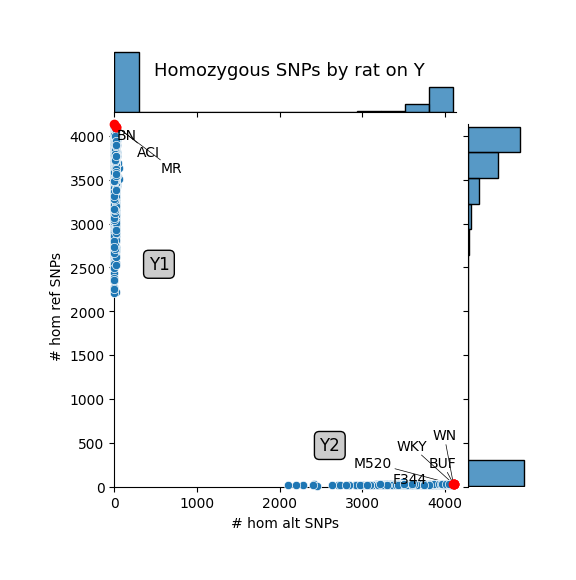

In [9]:
# Figure 1B
y_favors_ref = combined_hom_ref_vs_alt(y_founders, y_modern, 'Y')

# make sure everything is labelled correctly for the final file
y_groups = label_haplotypes(y_favors_ref, 'Y', ref_founder = 'ACI', 
                            alt_founder = 'M520')
y_groups.to_csv(genotype_helpers.Y_GROUPS_FILE, index_label = 'rfid')

print(f'{y_groups.shape[0]} RFIDs match to Y haplotype groups:')
y_groups.value_counts()

14971 RFIDs match to MT haplotype groups:


MT1 (BN)                     9287
MT2 (BUF/F344/M520/MR/WN)    5684
Name: MT_group, dtype: int64

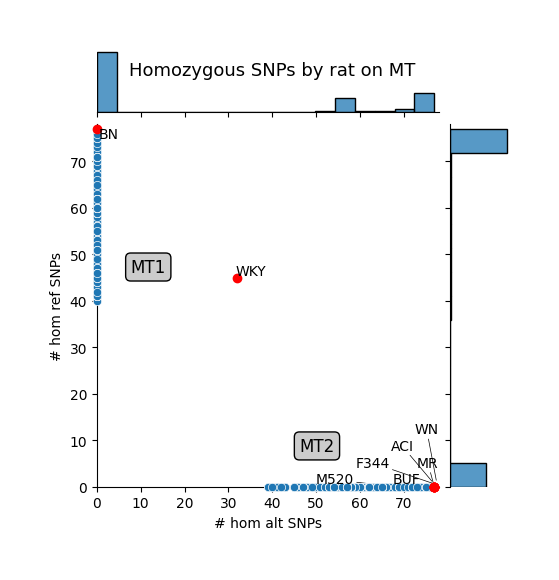

In [10]:
# Figure 2B
mt_favors_ref = combined_hom_ref_vs_alt(mt_founders, mt_modern, 'MT')

# make sure everything is labelled correctly for the final file
mt_groups = label_haplotypes(mt_favors_ref, 'MT', ref_founder = 'BN',
                             alt_founder = 'BUF/F344/M520/MR/WN')
mt_groups.to_csv(genotype_helpers.MT_GROUPS_FILE, index_label = 'rfid')

print(f'{mt_groups.shape[0]} RFIDs match to MT haplotype groups:')
mt_groups.value_counts()